In [1]:
# Webserver key: 1 is Control/User data, 2 is httpd/User data, 3 is nginx/User data, 4 is httpd/Connection data, 5 is nginx/Connection data, 6 is Control/Connection data

import os
from datetime import datetime

# Root directory based on the provided image
root_directory = "mitm_logs"


In [43]:
from collections import defaultdict
from tqdm import tqdm
# Function to extract time between attacker connection and attacker closed connection
def extract_time_difference(log_file_path):
    # Initialize variables
    connect_time, disconnect_time = None, None
    compromised = False
    interactive = True

    # Open the log file and read line by line
    with open(log_file_path, "r") as file:
        for line in file:
            if "Compromising the honeypot" in line:
                compromised = True
            if not compromised:
                continue

            if "[EXEC] Noninteractive mode attacker command:" in line:
                interactive = False
            
            if "Attacker authenticated and is inside container" in line:
                connect_time = datetime.strptime(line.split(" - ")[0], "%Y-%m-%d %H:%M:%S.%f")
            elif "[Connection] Attacker closed connection" in line:
                disconnect_time = datetime.strptime(line.split(" - ")[0], "%Y-%m-%d %H:%M:%S.%f")
                break

    # Calculate the difference if both times were found
    if connect_time and disconnect_time:
        difference = disconnect_time - connect_time
        return difference, interactive
    else:
        return None, False

# Loop through every webserver
noninteractive_webserver_times = defaultdict(list)
interactive_webserver_times = defaultdict(list)
webserver_times = defaultdict(list)

num_logs = defaultdict(int)


for webserver in tqdm(os.listdir(root_directory)):
    webserver_path = os.path.join(root_directory, webserver)

    # Loop through each date
    for date in os.listdir(webserver_path):
        date_path = os.path.join(webserver_path, date)

        # num_logs[webserver][date] = 0

        # Loop through each log file
        for log_file in os.listdir(date_path):
            num_logs[webserver] += 1
            log_file_path = os.path.join(date_path, log_file)
            
            # Extract time difference and print if found
            time_diff, interactive_session = extract_time_difference(log_file_path)
            if time_diff:
                # print(f"Webserver: {webserver}, Date: {date}, Log: {log_file}, Time Difference: {time_diff}")
            
                webserver_times[webserver].append(time_diff)
                if interactive_session:
                    interactive_webserver_times[webserver].append(time_diff)
                else:
                    noninteractive_webserver_times[webserver].append(time_diff)
# print(webserver_times)


100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


In [58]:
# get total length of all elements in noninteractive_webserver_times
total_length = 0
for webserver in noninteractive_webserver_times:
    total_length += len(webserver_times[webserver])
print(total_length)

33221


In [44]:
# get total number of logs
total_num_logs = 0
for webserver in num_logs:
    total_num_logs += num_logs[webserver]
print(total_num_logs)

33485


webserver4: 5642 logs, 16.85%
webserver3: 5532 logs, 16.52%
webserver2: 5573 logs, 16.64%
webserver5: 5488 logs, 16.39%
webserver6: 5554 logs, 16.59%
webserver1: 5696 logs, 17.01%


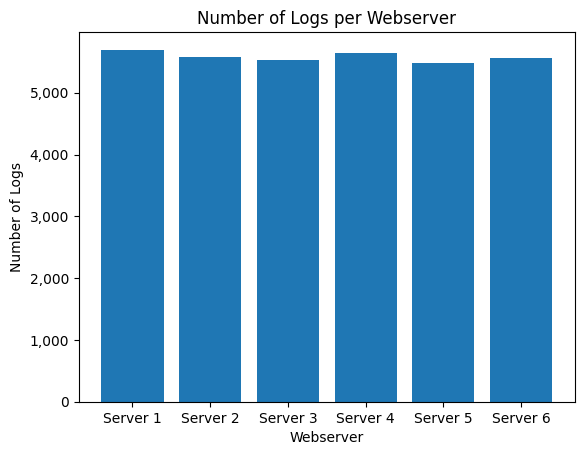

In [47]:
# analyze differences in num_logs, between webservers
for webserver in num_logs:
    print(f"{webserver}: {num_logs[webserver]} logs, {round(num_logs[webserver]/total_num_logs*100, 2)}%")

# make bar chart of num_logs, ordered by web server number
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Get the number of logs for each webserver
num_logs_list = [num_logs[f"webserver{i}"] for i in range(1, 7)]

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(np.arange(1, 7), num_logs_list)

# Set the x-axis tick labels
ax.set_xticks(np.arange(1, 7))
ax.set_xticklabels([f"Server {i}" for i in range(1, 7)])

# Set the y-axis tick formatter to use commas
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Set the axis labels and title
ax.set_xlabel("Webserver")
ax.set_ylabel("Number of Logs")
ax.set_title("Number of Logs per Webserver")

plt.show()


In [52]:
# organize into crosstab, with server type on one rows and data type on columns
import pandas as pd
import numpy as np
# first row has server 1 and 6 (Control server), second row has server 2 and 4 (httpd serveR), third row has server 3 and 5 (nginx server)
# first column has user data, second column has connection data
# create dataframe
df = pd.DataFrame(columns=["Control", "httpd", "nginx"], index=["User Data", "Connection Data"])
# fill dataframe
df.iloc[0, 0] = len(webserver_times["webserver1"])
df.iloc[0, 1] = len(webserver_times["webserver2"])
df.iloc[0, 2] = len(webserver_times["webserver3"])
df.iloc[1, 0] = len(webserver_times["webserver6"])
df.iloc[1, 1] = len(webserver_times["webserver4"])
df.iloc[1, 2] = len(webserver_times["webserver5"])

df

,Control,httpd,nginx
User Data,5640,5528,5486
Connection Data,5516,5601,5450


In [60]:
# Perform chi-squared test to see if the number of logs is significantly different between webservers
from scipy.stats import chisquare
print(chisquare(num_logs_list))

# Perform chi-squared test on crosstab
from scipy.stats import chi2_contingency
print(chi2_contingency(df))

# Perform chi-squared test on transposed crosstab
df_transposed = df.transpose()
print(chi2_contingency(df_transposed))

Power_divergenceResult(statistic=5.15851873973421, pvalue=0.3968424441425468)
Chi2ContingencyResult(statistic=1.7477927055151563, pvalue=0.4173223422671508, dof=2, expected_freq=array([[5592.60780831, 5579.07245417, 5482.31973752],
       [5563.39219169, 5549.92754583, 5453.68026248]]))
Chi2ContingencyResult(statistic=1.7477927055151565, pvalue=0.4173223422671508, dof=2, expected_freq=array([[5592.60780831, 5563.39219169],
       [5579.07245417, 5549.92754583],
       [5482.31973752, 5453.68026248]]))


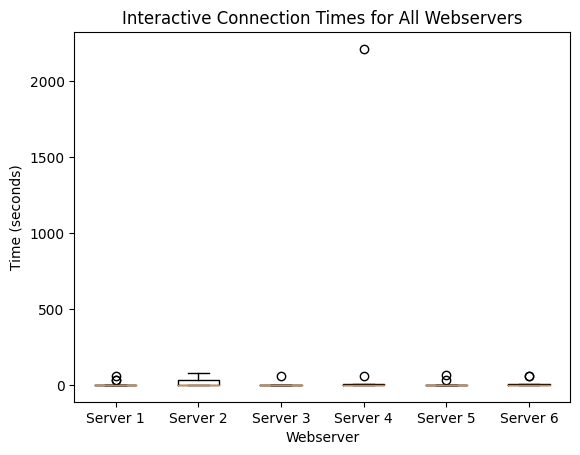

In [33]:
# make box plots for each webserver times
import matplotlib.pyplot as plt

# Whether to use interactive sessions or noninteractive sessions
interactive = True

# Create a list to store all timedeltas for each webserver
all_timedeltas = []


# Loop through every webserver
for webserver in [f'webserver{i}' for i in range(1, 7)]:
    if interactive:
        timedeltas = interactive_webserver_times[webserver]
    else:
        timedeltas = noninteractive_webserver_times[webserver]
    # turn datetime.timedelta into seconds
    timedeltas = [x.total_seconds() for x in timedeltas]
    all_timedeltas.append(timedeltas)

# Plot all boxplots on the same graph
plt.boxplot(all_timedeltas)
plt.xticks(range(1, 7), [f'Server {i}' for i in range(1, 7)])
plt.title("Interactive Connection Times for All Webservers" if interactive else "Noninteractive Connection Times for All Webservers")
plt.ylabel("Time (seconds)")
plt.xlabel("Webserver")
plt.show()



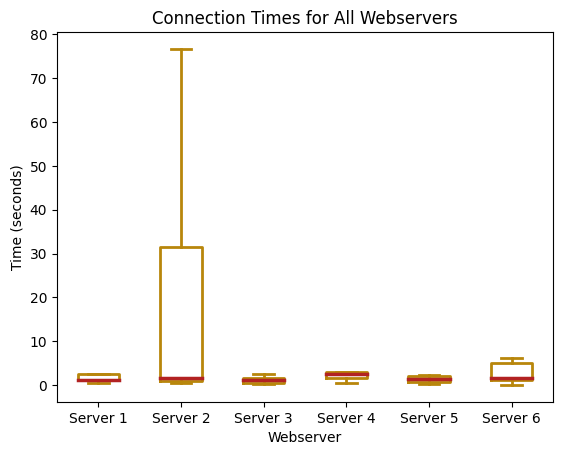

In [34]:
# Cut off the outliers
fig, ax = plt.subplots()
boxprops = dict(linestyle='-', linewidth=2, color='darkgoldenrod')
flierprops = dict(marker='o', markersize=5, markerfacecolor='black', alpha=0.5)
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
meanprops = dict(marker='D', markersize=5, markerfacecolor='blue', alpha=0.5)
capprops = dict(linestyle='-', linewidth=2, color='darkgoldenrod')
whiskerprops = dict(linestyle='-', linewidth=2, color='darkgoldenrod')
plt.boxplot(all_timedeltas, showfliers=False, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, meanprops=meanprops, capprops=capprops, whiskerprops=whiskerprops)
plt.title("Connection Times for All Webservers")
plt.ylabel("Time (seconds)")
plt.xlabel("Webserver")
plt.xticks(range(1, 7), [f'Server {i}' for i in range(1, 7)])
plt.show()

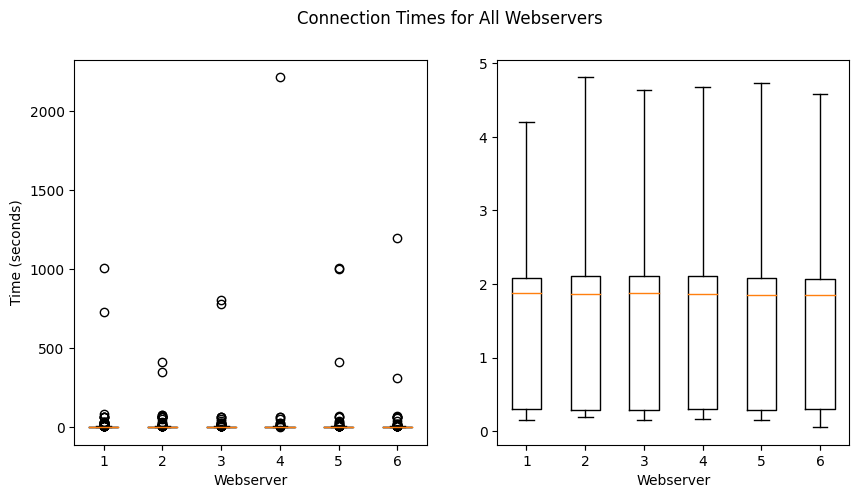

In [18]:
# Show the above two as subplots, with the title "Connection Times for All Webservers" and the y-axis label "Time (seconds)"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Connection Times for All Webservers")
ax1.set_ylabel("Time (seconds)")
ax1.set_xlabel("Webserver")
ax2.set_xlabel("Webserver")
ax1.set_xticks(range(1, 7))
ax2.set_xticks(range(1, 7))
ax1.set_xticklabels([f'Server {i}' for i in range(1, 7)])
ax2.set_xticklabels([f'Server {i}' for i in range(1, 7)])
ax1.boxplot(all_timedeltas)
ax2.boxplot(all_timedeltas, showfliers=False)
plt.show()

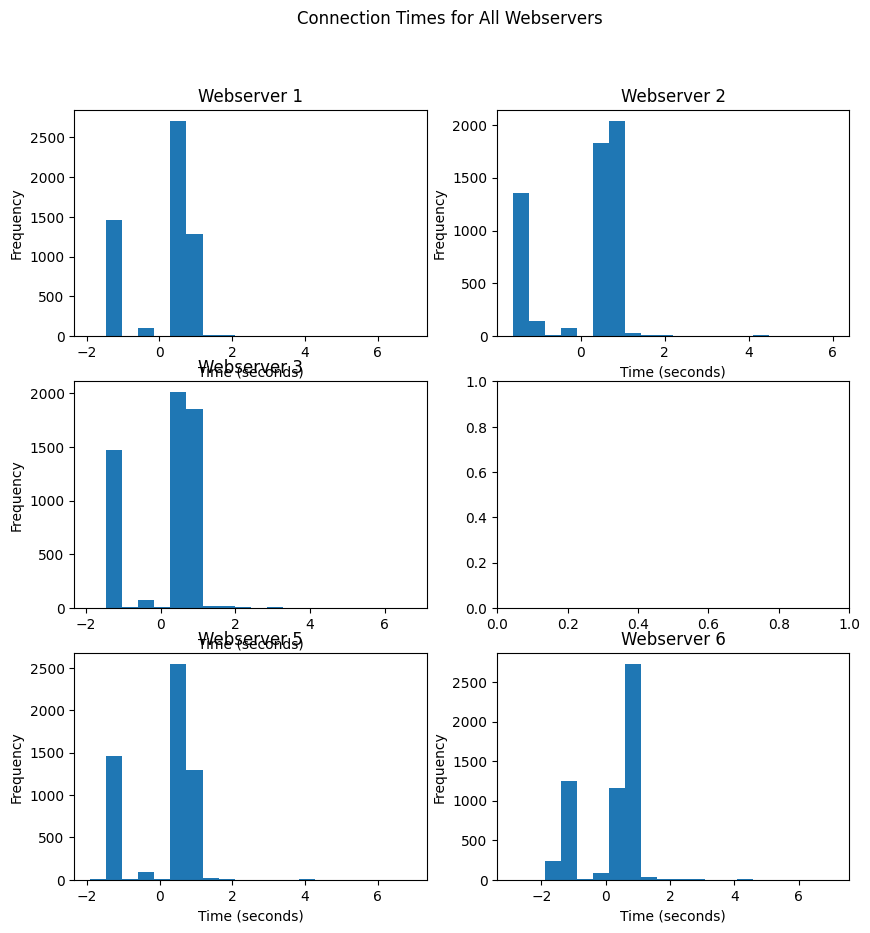

In [23]:
# Histogram of connection times for each webserver, shown on 3x2 box plots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle("Connection Times for All Webservers")
for i in range(3):
    for j in range(2):
        try:
            axs[i, j].hist([math.log(x) for x in all_timedeltas[i*2+j]], bins=20)
            axs[i, j].set_title(f"Webserver {i*2+j+1}")
            axs[i, j].set_xlabel("Time (seconds)")
            axs[i, j].set_ylabel("Frequency")
        except:
            pass

plt.show()

In [17]:
# Perform a statistical kruskal-wallis test to see if there is a significant difference between the means of the webserver times
from scipy.stats import kruskal
kruskal(*all_timedeltas)

KruskalResult(statistic=2.5896649837594508, pvalue=0.7629349178671567)